<a href="https://colab.research.google.com/github/MatteoTomasetto/SHRED-ROM/blob/main/DoubleGyreFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORT LIBRARIES

import torch
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

np.random.seed(2025)

## **Double gyre flow**

The double gyre flow is a time-dependent model for two counter-rotating vortices (gyres) in a rectangular domain. When time is introduced via a periodic perturbation, the central dividing line between the two gyres oscillates left and right, creating a time-varying velocity field that can lead to chaotic particle trajectories. The velocity field $\mathbf{v} = [u, v]^T$ in the domain $[0, L_x] \times [0, L_y]$ and in the time interval $[0, T]$ is given by

\
$$
\begin{align}
u(x, y, t) &= -\pi I \sin\left( \pi f(x, t) \right) \cos\left( \pi y \right)
\\
v(x, y, t) &= \pi I \cos\left( \pi f(x, t) \right) \sin\left( \pi y \right) \frac{\partial f}{\partial x}
\end{align}
$$

\
where $I$ is the intensity parameter, $f(x, t) = \epsilon \sin(\omega t) x^2 + (1 - 2\epsilon \sin(\omega t)) x $, $\epsilon$ and $\omega$ are the perturbation amplitude and the frequency of the oscillation, respectively.

In [2]:
# DEFINE THE SYSTEM SOLVER

def double_gyre_flow(amplitude, frequency, x, y, t):
    '''
    Solve the double gyre flow problem

    Inputs
        amplitude                   (`float`)
        frequency                   (`float`)
        horizontal discretization   (`np.array[float]`, shape: (ny,))
        vertical discretization     (`np.array[float]`, shape: (nx,))
        time vector                 (`np.array[float]`, shape: (ntimes,))

    Output
        horizontal velocity matrix  (`np.array[float]`, shape: (ntimes, nx * ny)
        vertical velocity matrix    (`np.array[float]`, shape: (ntimes, nx * ny)
    '''

    xgrid, ygrid = np.meshgrid(x, y)         # spatial grid

    u = np.zeros((len(t), len(x), len(y)))   # horizontal velocity
    v = np.zeros((len(t), len(x), len(y)))   # vertical velocity

    intensity = 0.1   # intensity parameter

    f = lambda x,t: amplitude * np.sin(frequency * t) * x**2 + x - 2 * amplitude * np.sin(frequency * t) * x

    # compute solution
    for i in range(len(t)):
      u[i] = (-np.pi * intensity * np.sin(np.pi * f(xgrid, t[i])) * np.cos(np.pi * ygrid)).T
      v[i] = (np.pi * intensity * np.cos(np.pi * f(xgrid, t[i])) * np.sin(np.pi * ygrid) * (2 * amplitude * np.sin(frequency * t[i]) * xgrid + 1.0 - 2 * amplitude * np.sin(frequency * t[i]))).T

    return u, v

In [3]:
# SOLVE THE SYSTEM FOR A FIXED TRANSPORT TERM

amplitude = 0.25    # amplitude
frequency = 5.0     # frequency

# spatial discretization
nx = 50
ny = 25
Lx = 2.0
Ly = 1.0
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
nstate = len(x) * len(y)

# temporal discretization
dt = 0.1
T = 10.0
t = np.arange(0, T + dt, dt)
ntimes = len(t)

u, v = double_gyre_flow(amplitude, frequency, x, y, t)

In [4]:
# SOLUTION VISUALIZATION

from ipywidgets import interact, FloatSlider
import matplotlib.patches as patches

def vorticity(u, v):
    dx = Lx / nx
    dy = Ly / ny
    du_dy = np.gradient(u, dy, axis = 1)
    dv_dx = np.gradient(v, dx, axis = 0)
    return dv_dx - du_dy

def plot_solution(time):

    which_time = (np.abs(t - time)).argmin()
    offset = 0.1

    plt.figure(figsize = (10,5))
    plt.contourf(x, y, vorticity(u[which_time], v[which_time]).T, cmap = 'seismic', levels = 100)
    plt.streamplot(x, y, u[which_time].T, v[which_time].T, color='black', linewidth = 1, density = 1)
    plt.axis('off')
    plt.axis([0 - offset, Lx + offset, 0 - offset, Ly + offset])
    plt.title(f'Solution at time t = {round(time, 3)}')
    plt.grid(True)
    plt.gca().add_patch(patches.Rectangle((0, 0), Lx, Ly, linewidth = 5, edgecolor = 'black', facecolor = 'none'))


interact(plot_solution, time = FloatSlider(value = t[0], min = t[0], max = t[-1], step = (t[1]-t[0]), description='time', layout={'width': '400px', 'height': '50px'}));

interactive(children=(FloatSlider(value=0.0, description='time', layout=Layout(height='50px', width='400px'), …

In [5]:
# DATA GENERATION

amplitude_range = np.array([0.0, 0.5])
frequency_range = np.array([0.5, 2*np.pi])

# spatial discretization
nx = 50
ny = 25
Lx = 2.0
Ly = 1.0
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
nstate = len(x) * len(y)

# temporal discretization
dt = 0.1
T = 10.0
t = np.arange(0, T + dt, dt)
ntimes = len(t)

# training data generation
ntrajectories = 100
U = np.zeros((ntrajectories, ntimes, nx, ny))
V = np.zeros((ntrajectories, ntimes, nx, ny))

for i in range(ntrajectories):
  amplitude = (amplitude_range[1] - amplitude_range[0]) * np.random.rand() + amplitude_range[0]
  frequency = (frequency_range[1] - frequency_range[0]) * np.random.rand() + frequency_range[0]
  U[i], V[i] = double_gyre_flow(amplitude, frequency, x, y, t)

In [6]:
# DATA VISUALIZATION

from ipywidgets import interact, IntSlider

def plot_data(which_trajectory, which_time):

    offset = 0.1

    plt.figure(figsize = (10,5))
    plt.contourf(x, y, vorticity(U[which_trajectory, which_time], V[which_trajectory, which_time]).T, cmap = 'seismic', levels = 100)
    plt.streamplot(x, y, U[which_trajectory, which_time].T, V[which_trajectory, which_time].T, color='black', linewidth = 1, density = 1)
    plt.axis('off')
    plt.axis([0 - offset, Lx + offset, 0 - offset, Ly + offset])
    plt.title(f'Trajectory {which_trajectory} at time t = {round(t[which_time], 3)}')
    plt.grid(True)
    plt.gca().add_patch(patches.Rectangle((0, 0), Lx, Ly, linewidth = 5, edgecolor = 'black', facecolor = 'none'))

interact(plot_data, which_trajectory = IntSlider(min = 0, max = ntrajectories - 1, step = 1, description='Trajectory'), which_time = IntSlider(min = 0, max = ntimes - 1, step = 1, description='Time step'));

interactive(children=(IntSlider(value=0, description='Trajectory', max=99), IntSlider(value=0, description='Ti…

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [7]:
# TORCH CONVERSION

U = torch.from_numpy(U.reshape(ntrajectories, ntimes, nstate))
V = torch.from_numpy(V.reshape(ntrajectories, ntimes, nstate))

In [8]:
# TRAIN-VALIDATION SPLITTING

split_ratio = 0.8

ntrain = round(split_ratio * ntrajectories)

idx_train = np.random.choice(ntrajectories, size = ntrain, replace = False)
mask = np.ones(ntrajectories)
mask[idx_train] = 0
idx_valid_test = np.arange(0, ntrajectories)[np.where(mask!=0)[0]]
idx_valid = idx_valid_test[::2]
idx_test = idx_valid_test[1::2]

nvalid = idx_valid.shape[0]
ntest = idx_test.shape[0]

Utrain = U[idx_train]
Uvalid = U[idx_valid]
Utest = U[idx_test]

Vtrain = V[idx_train]
Vvalid = V[idx_valid]
Vtest = V[idx_test]

## **SHallow REcurrent Decoder networks-based Reduced Order Modeling (SHRED-ROM)**

Let us assume to have three sensors in the domain measuring the horizontal velocity $u(x_s,y_s,t;\epsilon, \omega)$ over time. *SHRED-ROM* aims to reconstruct the temporal evolution of the entire velocity $\mathbf{v}(x,y,t;\epsilon, \omega) = [u(x,y,t;\epsilon, \omega), v(x,y,t;\epsilon, \omega)]^T$ starting from the limited sensor measurements available. In general, *SHRED-ROM* combines a recurrent neural network (LSTM), which encodes the temporal history of sensor values in multiple parametric regimes, and a shallow decoder, which projects the LSTM prediction to the (possibly high-dimensional) state dimension. Note that, to enhance computational efficiency and memory usage, dimensionality reduction strategies (such as, e.g., POD or Fourier modes) may be considered to compress the training snapshots.


## POD-based compressive training

Residual energy is equal to  6.189785026138091e-07



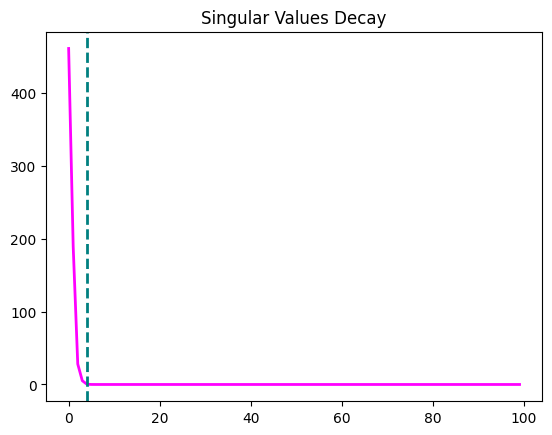

In [9]:
# DIMENSIONALITY REDUCTION - HORIZONTAL VELOCITY

Utrain = Utrain.reshape(-1, nstate)
Uvalid = Uvalid.reshape(-1, nstate)
Utest = Utest.reshape(-1, nstate)

U1_POD, S1_POD, V1_POD = np.linalg.svd(Utrain, full_matrices = False)
POD_modes = 4

Utrain_proj = Utrain @ V1_POD[:POD_modes, :].T
Utrain_proj = Utrain_proj.reshape(ntrain, ntimes, POD_modes)
Utrain = Utrain.reshape(ntrain, ntimes, nstate)

Uvalid_proj = Uvalid @ V1_POD[:POD_modes, :].T
Uvalid_proj = Uvalid_proj.reshape(nvalid, ntimes, POD_modes)
Uvalid = Uvalid.reshape(nvalid, ntimes, nstate)

Utest_proj = Utest @ V1_POD[:POD_modes, :].T
Utest_proj = Utest_proj.reshape(ntest, ntimes, POD_modes)
Utest = Utest.reshape(ntest, ntimes, nstate)

print(f"Residual energy is equal to  {np.sum(S1_POD[POD_modes:]**2) / np.sum(S1_POD**2)}\n")
plt.plot(S1_POD[:100], color = 'magenta', linewidth = 2)
plt.axvline(POD_modes, color = 'teal', linestyle = '--', linewidth = 2)
plt.title("Singular Values Decay");

Residual energy is equal to  5.280659835332122e-06



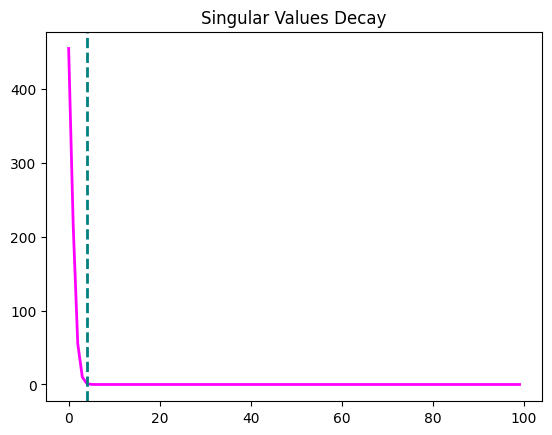

In [10]:
# DIMENSIONALITY REDUCTION - VERTICAL VELOCITY

Vtrain = Vtrain.reshape(-1, nstate)
Vvalid = Vvalid.reshape(-1, nstate)
Vtest = Vtest.reshape(-1, nstate)

U2_POD, S2_POD, V2_POD = np.linalg.svd(Vtrain, full_matrices = False)
POD_modes = 4

Vtrain_proj = Vtrain @ V2_POD[:POD_modes, :].T
Vtrain_proj = Vtrain_proj.reshape(ntrain, ntimes, POD_modes)
Vtrain = Vtrain.reshape(ntrain, ntimes, nstate)

Vvalid_proj = Vvalid @ V2_POD[:POD_modes, :].T
Vvalid_proj = Vvalid_proj.reshape(nvalid, ntimes, POD_modes)
Vvalid = Vvalid.reshape(nvalid, ntimes, nstate)

Vtest_proj = Vtest @ V2_POD[:POD_modes, :].T
Vtest_proj = Vtest_proj.reshape(ntest, ntimes, POD_modes)
Vtest = Vtest.reshape(ntest, ntimes, nstate)

print(f"Residual energy is equal to  {np.sum(S2_POD[POD_modes:]**2) / np.sum(S2_POD**2)}\n")
plt.plot(S2_POD[:100], color = 'magenta', linewidth = 2)
plt.axvline(POD_modes, color = 'teal', linestyle = '--', linewidth = 2)
plt.title("Singular Values Decay");

In [11]:
# POD MODES VISUALIZATION

def plot_POD_modes(which):

    offset = 0.1

    plt.figure(figsize = (20,5))

    plt.subplot(1, 2, 1)
    plt.contourf(x, y, V1_POD[which].reshape(nx, ny).T, cmap = 'seismic', levels = 100)
    plt.axis('off')
    plt.axis([0 - offset, Lx + offset, 0 - offset, Ly + offset])
    plt.title(f'u - POD mode {which}')
    plt.grid(True)
    plt.gca().add_patch(patches.Rectangle((0, 0), Lx, Ly, linewidth = 5, edgecolor = 'black', facecolor = 'none'))

    plt.subplot(1, 2, 2)
    plt.contourf(x, y, V2_POD[which].reshape(nx, ny).T, cmap = 'seismic', levels = 100)
    plt.axis('off')
    plt.axis([0 - offset, Lx + offset, 0 - offset, Ly + offset])
    plt.title(f'v - POD mode {which}')
    plt.grid(True)
    plt.gca().add_patch(patches.Rectangle((0, 0), Lx, Ly, linewidth = 5, edgecolor = 'black', facecolor = 'none'))

interact(plot_POD_modes, which = IntSlider(min = 0, max = POD_modes - 1, step = 1, description='POD mode'));

interactive(children=(IntSlider(value=0, description='POD mode', max=3), Output()), _dom_classes=('widget-inte…

In [12]:
# DEFINE FUNCTION TO PROCESS DATA

class TimeSeriesDataset(torch.utils.data.Dataset):
    '''
    Define a dataset of input-output time-series

    Inputs
        sequence of input measurements    (`torch.Tensor[float]`, shape: (ntrajectories, ntimes, ninput))
        state measurements                (`torch.Tensor[float]`, shape: (ntrajectories, ntimes, noutput))

    Output
        Torch dataset                     (`torch.utils.data.Dataset`)
    '''

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.len = X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def __len__(self):
        return self.len


def Padding(data, lag):
    '''
    Extract time-series of lenght equal to lag from longer time series in data

    Inputs
        time-series data          (`torch.Tensor[float]`, shape: (ntrajectories, ntimes, ninput))
        lag parameter             (`int`)

    Input
        lagged time-series data   (`torch.Tensor[float]`, shape: (ntrajectories * ntimes, lag, ninput))
    '''

    data_out = torch.zeros(data.shape[0] * data.shape[1], lag, data.shape[2])

    for i in range(data.shape[0]):
        for j in range(1, data.shape[1] + 1):
            if j < lag:
                data_out[i * data.shape[1] + j - 1, -j:] = data[i, :j]
            else:
                data_out[i * data.shape[1] + j - 1] = data[i, j - lag : j]

    return data_out

In [13]:
# DEFINE SHRED MODEL

class SHRED(torch.nn.Module):

    def __init__(self, input_size, output_size, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.0):
        '''
        SHRED model definition

        Inputs
        	input size (e.g. number of sensors)                 (`int`)
        	output size (e.g. full-order variable dimension)    (`int`)
        	size of LSTM hidden layers                          (`int`)
        	number of LSTM hidden layers                        (`int`)
        	list of decoder layers sizes                        (`list[int]`)
        	dropout parameter                                   (`float`)
        '''

        super(SHRED,self).__init__()

        self.lstm = torch.nn.LSTM(input_size = input_size,
                                  hidden_size = hidden_size,
                                  num_layers = hidden_layers,
                                  batch_first=True)

        self.decoder = torch.nn.ModuleList()
        decoder_sizes.insert(0, hidden_size)
        decoder_sizes.append(output_size)

        for i in range(len(decoder_sizes)-1):
            self.decoder.append(torch.nn.Linear(decoder_sizes[i], decoder_sizes[i+1]))
            if i != len(decoder_sizes)-2:
                self.decoder.append(torch.nn.Dropout(dropout))
                self.decoder.append(torch.nn.ReLU())

        self.hidden_layers = hidden_layers
        self.hidden_size = hidden_size

    def forward(self, x):

        h_0 = torch.zeros((self.hidden_layers, x.size(0), self.hidden_size), dtype=torch.float)
        c_0 = torch.zeros((self.hidden_layers, x.size(0), self.hidden_size), dtype=torch.float)
        if next(self.parameters()).is_cuda:
            h_0 = h_0.cuda()
            c_0 = c_0.cuda()

        _, (output, _) = self.lstm(x, (h_0, c_0))
        output = output[-1].view(-1, self.hidden_size)

        for layer in self.decoder:
            output = layer(output)

        return output

    def freeze(self):

        self.eval()

        for param in self.parameters():
            param.requires_grad = False

    def unfreeze(self):

        self.train()

        for param in self.parameters():
            param.requires_grad = True


In [14]:
# DEFINE TRAINING FUNCTION

from torch.utils.data import DataLoader
from copy import deepcopy
from IPython.display import clear_output as clc

mse = lambda datatrue, datapred: (datatrue - datapred).pow(2).sum(axis = -1).mean()  # Mean Squared Error
error_formatter = lambda error: ".6f" % error

def fit(model, train_dataset, valid_dataset, batch_size = 64, epochs = 4000, optim = torch.optim.Adam, lr = 1e-3, loss_fun = mse, loss_output = mse, formatter = error_formatter, verbose = False, patience = 5):
    '''
    Neural networks training

    Inputs
    	model                                 (`torch.nn.Module`)
    	training dataset                      (`torch.Tensor`)
    	validation dataset                    (`torch.Tensor`)
    	batch size                            (`int`)
    	number of epochs                      (`int`)
    	optimizer                             (`function`)
    	learning rate                         (`float`)
      loss function                         (`function`)
      loss value to print and return        (`function`)
      loss formatter for printing           (`function`)
    	verbose parameter                     (`bool`)
    	patience parameter                    (`int`)
    '''

    train_loader = DataLoader(train_dataset, shuffle = True, batch_size = batch_size)
    optimizer = optim(model.parameters(), lr = lr)

    train_error_list = []
    valid_error_list = []
    patience_counter = 0
    best_params = model.state_dict()

    for epoch in range(1, epochs + 1):

        for k, data in enumerate(train_loader):
            model.train()
            def closure():
                outputs = model(data[0])
                optimizer.zero_grad()
                loss = loss_fun(outputs, data[1])
                loss.backward()
                return loss
            optimizer.step(closure)

        model.eval()
        with torch.no_grad():
            train_error = loss_output(train_dataset.Y, model(train_dataset.X))
            valid_error = loss_output(valid_dataset.Y, model(valid_dataset.X))
            train_error_list.append(train_error)
            valid_error_list.append(valid_error)

        if verbose == True:
            print("Epoch "+ str(epoch) + ": Training loss = " + "%.6f" % train_error_list[-1] + " \t Validation loss = " + "%.6f" % valid_error_list[-1])
            clc(wait = True)

        if valid_error == torch.min(torch.tensor(valid_error_list)):
            patience_counter = 0
            best_params = deepcopy(model.state_dict())
        else:
            patience_counter += 1

        if patience_counter == patience:
            model.load_state_dict(best_params)
            train_error = loss_output(train_dataset.Y, model(train_dataset.X))
            valid_error = loss_output(valid_dataset.Y, model(valid_dataset.X))

            if verbose == True:
                print("Training done: Training loss = " + "%.6f" % train_error + " \t Validation loss = " + "%.6f" % valid_error)

            return torch.tensor(train_error_list).detach().cpu().numpy(), torch.tensor(valid_error_list).detach().cpu().numpy()

    model.load_state_dict(best_params)
    train_error = loss_output(train_dataset.Y, model(train_dataset.X))
    valid_error = loss_output(valid_dataset.Y, model(valid_dataset.X))

    if verbose == True:
      print("Training done: Training loss = " + "%.6f" % train_error + " \t Validation loss = " + "%.6f" % valid_error)

    return torch.tensor(train_error_list).detach().cpu().numpy(), torch.tensor(valid_error_list).detach().cpu().numpy()

In [15]:
# EXTRACT SENSORS DATA

nsensors = 3
idx_sensors = np.random.choice(nstate, size = nsensors, replace = False)

sensors_data_train = Utrain[:,:,idx_sensors]
sensors_data_valid = Uvalid[:,:,idx_sensors]
sensors_data_test = Utest[:,:,idx_sensors]

idx_sensors_x, idx_sensors_y = np.unravel_index(idx_sensors, (nx, ny))
sensors_coordinates = np.vstack((x[idx_sensors_x], y[idx_sensors_y]))

In [16]:
# BUILD TRAIN, VALIDATION AND TEST DATASETS WITH PADDING

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lag = 25

train_data_in = Padding(sensors_data_train, lag).to(device)
valid_data_in = Padding(sensors_data_valid, lag).to(device)
test_data_in = Padding(sensors_data_test, lag).to(device)

train_data_out = Padding(torch.cat((Utrain_proj, Vtrain_proj), 2), 1).squeeze(1).to(device)
valid_data_out = Padding(torch.cat((Uvalid_proj, Vvalid_proj), 2), 1).squeeze(1).to(device)
test_data_out = Padding(torch.cat((Utest_proj, Vtest_proj), 2), 1).squeeze(1).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [17]:
# SHRED TRAINING

shred = SHRED(nsensors, 2*POD_modes, hidden_size = 64, hidden_layers = 2, decoder_sizes = [], dropout = 0.1).to(device)
train_errors, valid_errors = fit(shred, train_dataset, valid_dataset, batch_size = 64, epochs = 100, lr = 1e-3, verbose = True, patience = 100)

Training done: Training loss = 0.004959 	 Validation loss = 0.005806


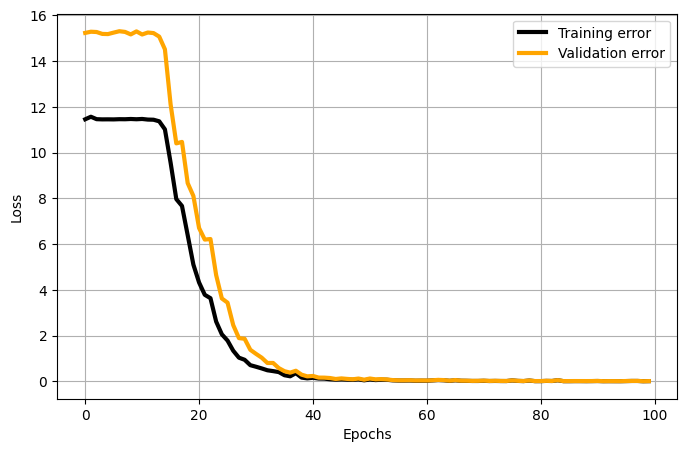

In [18]:
# TRAINING HISTORY VISUALIZATION

plt.figure(figsize = (8,5))
plt.plot(train_errors, 'k', linewidth = 3, label = 'Training error')
plt.plot(valid_errors, 'orange', linewidth = 3, label = 'Validation error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

interactive(children=(IntSlider(value=0, description='Test case', max=9), IntSlider(value=0, description='Time…

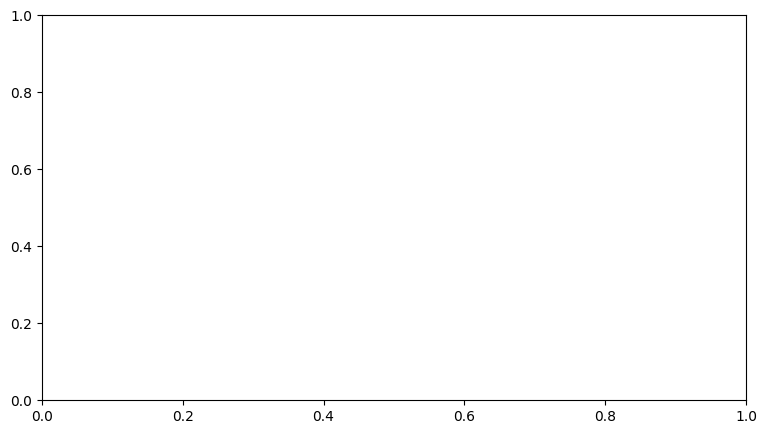

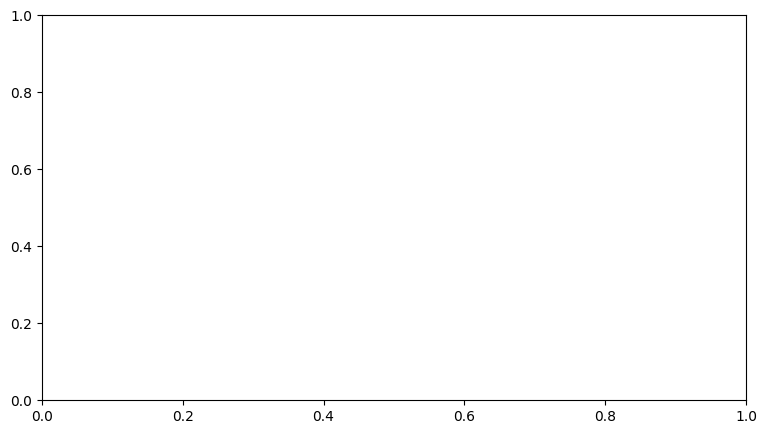

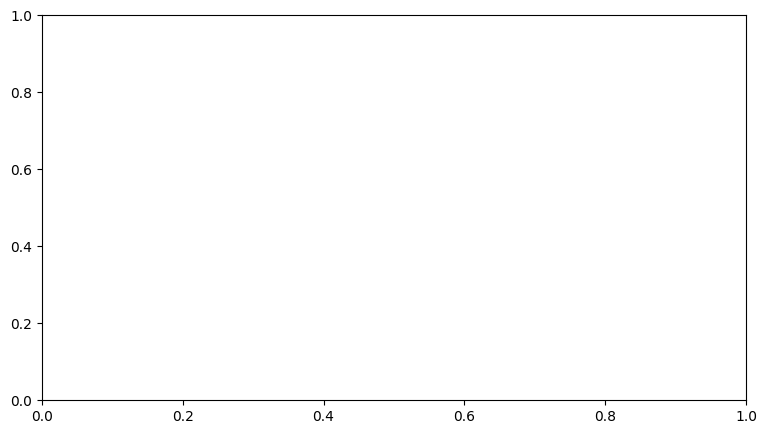

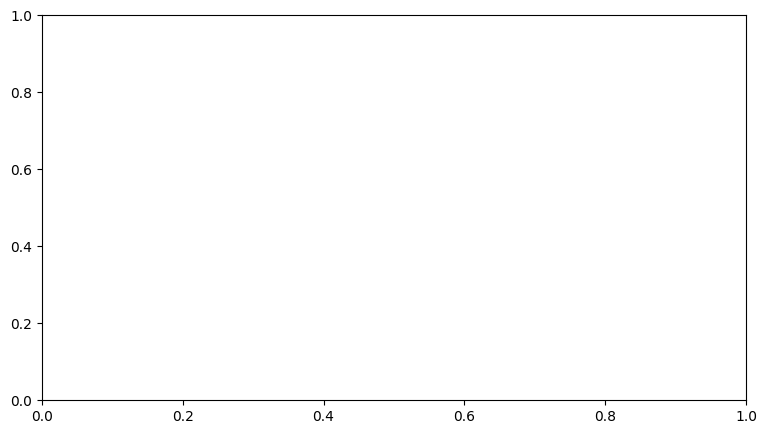

In [19]:
# SHRED RECONSTRUCTION VISUALIZATION

from ipywidgets import interact, IntSlider

shred.freeze()

UVtest_hat = shred(test_data_in).cpu().to(torch.float64)

Utest_hat = UVtest_hat[:,:POD_modes] @ V1_POD[:POD_modes, :]
Utest_hat = Utest_hat.reshape(ntest, ntimes, nx, ny)
Utest = Utest.reshape(ntest, ntimes, nx, ny)

Vtest_hat = UVtest_hat[:,POD_modes:] @ V2_POD[:POD_modes, :]
Vtest_hat = Vtest_hat.reshape(ntest, ntimes, nx, ny)
Vtest = Vtest.reshape(ntest, ntimes, nx, ny)

def plot_shred_reconstruction(which_test_trajectory, which_time):

    offset = 0.1

    plt.figure(figsize = (20,5))
    plt.subplot(1, 2, 1)
    plt.contourf(x, y, vorticity(Utest[which_test_trajectory, which_time],  Vtest[which_test_trajectory, which_time]).T, cmap = 'seismic', levels = 100)
    plt.streamplot(x, y, Utest[which_test_trajectory, which_time].T, Vtest[which_test_trajectory, which_time].T, color='black', linewidth = 1, density = 1)
    plt.axis('off')
    plt.axis([0 - offset, Lx + offset, 0 - offset, Ly + offset])
    plt.title(f'Test case {which_test_trajectory} at time t = {round(t[which_time], 3)}')
    plt.grid(True)
    plt.gca().add_patch(patches.Rectangle((0, 0), Lx, Ly, linewidth = 5, edgecolor = 'black', facecolor = 'none'))
    for k in range(nsensors):
      plt.plot(sensors_coordinates[0, k], sensors_coordinates[1, k], 'o', mfc = 'magenta', mec = 'black', ms = 8, mew = 1.5)

    plt.subplot(1, 2, 2)
    plt.contourf(x, y, vorticity(Utest_hat[which_test_trajectory, which_time],  Vtest_hat[which_test_trajectory, which_time]).T, cmap = 'seismic', levels = 100)
    plt.streamplot(x, y, Utest_hat[which_test_trajectory, which_time].T, Vtest_hat[which_test_trajectory, which_time].T, color='black', linewidth = 1, density = 1)
    plt.axis('off')
    plt.axis([0 - offset, Lx + offset, 0 - offset, Ly + offset])
    plt.title(f'SHRED reconstruction at time t = {round(t[which_time], 3)}')
    plt.grid(True)
    plt.gca().add_patch(patches.Rectangle((0, 0), Lx, Ly, linewidth = 5, edgecolor = 'black', facecolor = 'none'))
    for k in range(nsensors):
      plt.plot(sensors_coordinates[0, k], sensors_coordinates[1, k], 'o', mfc = 'magenta', mec = 'black', ms = 8, mew = 1.5)

interact(plot_shred_reconstruction, which_test_trajectory = IntSlider(value = 0, min = 0, max = ntest - 1, description='Test case'), which_time = IntSlider(min = 0, max = ntimes - 1, step = 1, description='Time step'));

## Fourier-based compressive training

In [20]:
# DIMENSIONALITY REDUCTION - HORIZONTAL VELOCITY

Utrain = Utrain.reshape(ntrain, ntimes, nstate)
Uvalid = Uvalid.reshape(nvalid, ntimes, nstate)
Utest = Utest.reshape(ntest, ntimes, nstate)

freq_cutoff = 0.05

freq_x = np.fft.fftfreq(nx)
freq_y = np.fft.fftfreq(ny)
freq_x_grid, freq_y_grid = np.meshgrid(freq_x, freq_y)
mask_x = np.abs(freq_x_grid.T) <= freq_cutoff

Utrain_fft = np.fft.fft2(Utrain.reshape(ntrain, ntimes, nx, ny), axes = (-2, -1))
Utrain_fft[:,:,~mask_x] = 0
Utrain_proj = torch.from_numpy(Utrain_fft[:,:,mask_x])
Utrain_reconstruction = np.fft.ifft2(Utrain_fft).real

Uvalid_fft = np.fft.fft2(Uvalid.reshape(nvalid, ntimes, nx, ny), axes = (-2, -1))
Uvalid_fft[:,:,~mask_x] = 0
Uvalid_proj = torch.from_numpy(Uvalid_fft[:,:,mask_x])
Uvalid_reconstruction = np.fft.ifft2(Uvalid_fft).real

Utest_fft = np.fft.fft2(Utest.reshape(ntest, ntimes, nx, ny), axes = (-2, -1))
Utest_fft[:,:,~mask_x] = 0
Utest_proj = torch.from_numpy(Utest_fft[:,:,mask_x])
Utest_reconstruction = np.fft.ifft2(Utest_fft).real

Fourier_modes_x = Utrain_proj.shape[-1]

print(f'Horizontal velocity projected onto {Fourier_modes_x} Fourier modes')

Horizontal velocity projected onto 125 Fourier modes


In [21]:
# DIMENSIONALITY REDUCTION - VERTICAL VELOCITY

Vtrain = Vtrain.reshape(ntrain, ntimes, nstate)
Vvalid = Vvalid.reshape(nvalid, ntimes, nstate)
Vtest = Vtest.reshape(ntest, ntimes, nstate)

freq_cutoff = 0.05

freq_x = np.fft.fftfreq(nx)
freq_y = np.fft.fftfreq(ny)
freq_x_grid, freq_y_grid = np.meshgrid(freq_x, freq_y)
mask_y = np.abs(freq_y_grid.T) <= freq_cutoff

Vtrain_fft = np.fft.fft2(Vtrain.reshape(ntrain, ntimes, nx, ny), axes = (-2, -1))
Vtrain_fft[:,:,~mask_y] = 0
Vtrain_proj = torch.from_numpy(Vtrain_fft[:,:,mask_y])
Vtrain_reconstruction = np.fft.ifft2(Vtrain_fft).real

Vvalid_fft = np.fft.fft2(Vvalid.reshape(nvalid, ntimes, nx, ny), axes = (-2, -1))
Vvalid_fft[:,:,~mask_y] = 0
Vvalid_proj = torch.from_numpy(Vvalid_fft[:,:,mask_y])
Vvalid_reconstruction = np.fft.ifft2(Vvalid_fft).real

Vtest_fft = np.fft.fft2(Vtest.reshape(ntest, ntimes, nx, ny), axes = (-2, -1))
Vtest_fft[:,:,~mask_y] = 0
Vtest_proj = torch.from_numpy(Vtest_fft[:,:,mask_y])
Vtest_reconstruction = np.fft.ifft2(Vtest_fft).real

Fourier_modes_y = Vtrain_proj.shape[-1]

print(f'Vertical velocity projected onto {Fourier_modes_y} Fourier modes')

Vertical velocity projected onto 150 Fourier modes


In [22]:
# FOURIER RECONSTRUCTION VISUALIZATION

def plot_fourier_data(which_test_trajectory, which_time):

    offset = 0.1

    plt.figure(figsize = (20,5))
    plt.subplot(1, 2, 1)
    plt.contourf(x, y, vorticity(Utest[which_test_trajectory, which_time].reshape(nx, ny),  Vtest[which_test_trajectory, which_time].reshape(nx, ny)).T, cmap = 'seismic', levels = 100)
    plt.streamplot(x, y, Utest[which_test_trajectory, which_time].reshape(nx, ny).T, Vtest[which_test_trajectory, which_time].reshape(nx, ny).T, color='black', linewidth = 1, density = 1)
    plt.axis('off')
    plt.axis([0 - offset, Lx + offset, 0 - offset, Ly + offset])
    plt.title(f'Test case {which_test_trajectory} at time t = {round(t[which_time], 3)}')
    plt.grid(True)
    plt.gca().add_patch(patches.Rectangle((0, 0), Lx, Ly, linewidth = 5, edgecolor = 'black', facecolor = 'none'))

    plt.subplot(1, 2, 2)
    plt.contourf(x, y, vorticity(Utest_reconstruction[which_test_trajectory, which_time].reshape(nx, ny),  Vtest_reconstruction[which_test_trajectory, which_time].reshape(nx, ny)).T, cmap = 'seismic', levels = 100)
    plt.streamplot(x, y, Utest_reconstruction[which_test_trajectory, which_time].reshape(nx, ny).T, Vtest_reconstruction[which_test_trajectory, which_time].reshape(nx, ny).T, color='black', linewidth = 1, density = 1)
    plt.axis('off')
    plt.axis([0 - offset, Lx + offset, 0 - offset, Ly + offset])
    plt.title(f'Fourier reconstruction at time t = {round(t[which_time], 3)}')
    plt.grid(True)
    plt.gca().add_patch(patches.Rectangle((0, 0), Lx, Ly, linewidth = 5, edgecolor = 'black', facecolor = 'none'))

interact(plot_fourier_data, which_test_trajectory = IntSlider(min = 0, max = ntest - 1, step = 1, description='Test case'), which_time = IntSlider(min = 0, max = ntimes - 1, step = 1, description='Time step'));

interactive(children=(IntSlider(value=0, description='Test case', max=9), IntSlider(value=0, description='Time…

In [23]:
# DEFINE FUNCTION TO PROCESS DATA

class TimeSeriesDataset(torch.utils.data.Dataset):
    '''
    Define a dataset of input-output time-series

    Inputs
        sequence of input measurements    (`torch.Tensor[float]`, shape: (ntrajectories, ntimes, ninput))
        state measurements                (`torch.Tensor[float]`, shape: (ntrajectories, ntimes, noutput))

    Output
        Torch dataset                     (`torch.utils.data.Dataset`)
    '''

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.len = X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def __len__(self):
        return self.len


def Padding(data, lag):
    '''
    Extract time-series of lenght equal to lag from longer time series in data

    Inputs
        time-series data          (`torch.Tensor[float]`, shape: (ntrajectories, ntimes, ninput))
        lag parameter             (`int`)

    Input
        lagged time-series data   (`torch.Tensor[float]`, shape: (ntrajectories * ntimes, lag, ninput))
    '''

    data_out = torch.zeros(data.shape[0] * data.shape[1], lag, data.shape[2])

    for i in range(data.shape[0]):
        for j in range(1, data.shape[1] + 1):
            if j < lag:
                data_out[i * data.shape[1] + j - 1, -j:] = data[i, :j]
            else:
                data_out[i * data.shape[1] + j - 1] = data[i, j - lag : j]

    return data_out

In [24]:
# DEFINE SHRED MODEL

class SHRED(torch.nn.Module):

    def __init__(self, input_size, output_size, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.0):
        '''
        SHRED model definition

        Inputs
        	input size (e.g. number of sensors)                 (`int`)
        	output size (e.g. full-order variable dimension)    (`int`)
        	size of LSTM hidden layers                          (`int`)
        	number of LSTM hidden layers                        (`int`)
        	list of decoder layers sizes                        (`list[int]`)
        	dropout parameter                                   (`float`)
        '''

        super(SHRED,self).__init__()

        self.lstm = torch.nn.LSTM(input_size = input_size,
                                  hidden_size = hidden_size,
                                  num_layers = hidden_layers,
                                  batch_first=True)

        self.decoder = torch.nn.ModuleList()
        decoder_sizes.insert(0, hidden_size)
        decoder_sizes.append(output_size)

        for i in range(len(decoder_sizes)-1):
            self.decoder.append(torch.nn.Linear(decoder_sizes[i], decoder_sizes[i+1]))
            if i != len(decoder_sizes)-2:
                self.decoder.append(torch.nn.Dropout(dropout))
                self.decoder.append(torch.nn.ReLU())

        self.hidden_layers = hidden_layers
        self.hidden_size = hidden_size

    def forward(self, x):

        h_0 = torch.zeros((self.hidden_layers, x.size(0), self.hidden_size), dtype=torch.float)
        c_0 = torch.zeros((self.hidden_layers, x.size(0), self.hidden_size), dtype=torch.float)
        if next(self.parameters()).is_cuda:
            h_0 = h_0.cuda()
            c_0 = c_0.cuda()

        _, (output, _) = self.lstm(x, (h_0, c_0))
        output = output[-1].view(-1, self.hidden_size)

        for layer in self.decoder:
            output = layer(output)

        return output

    def freeze(self):

        self.eval()

        for param in self.parameters():
            param.requires_grad = False

    def unfreeze(self):

        self.train()

        for param in self.parameters():
            param.requires_grad = True


In [25]:
# DEFINE TRAINING FUNCTION

from torch.utils.data import DataLoader
from copy import deepcopy
from IPython.display import clear_output as clc

mse = lambda datatrue, datapred: (datatrue - datapred).pow(2).sum(axis = -1).mean()  # Mean Squared Error
error_formatter = lambda error: ".6f" % error

def fit(model, train_dataset, valid_dataset, batch_size = 64, epochs = 4000, optim = torch.optim.Adam, lr = 1e-3, loss_fun = mse, loss_output = mse, formatter = error_formatter, verbose = False, patience = 5):
    '''
    Neural networks training

    Inputs
    	model                                 (`torch.nn.Module`)
    	training dataset                      (`torch.Tensor`)
    	validation dataset                    (`torch.Tensor`)
    	batch size                            (`int`)
    	number of epochs                      (`int`)
    	optimizer                             (`function`)
    	learning rate                         (`float`)
      loss function                         (`function`)
      loss value to print and return        (`function`)
      loss formatter for printing           (`function`)
    	verbose parameter                     (`bool`)
    	patience parameter                    (`int`)
    '''

    train_loader = DataLoader(train_dataset, shuffle = True, batch_size = batch_size)
    optimizer = optim(model.parameters(), lr = lr)

    train_error_list = []
    valid_error_list = []
    patience_counter = 0
    best_params = model.state_dict()

    for epoch in range(1, epochs + 1):

        for k, data in enumerate(train_loader):
            model.train()
            def closure():
                outputs = model(data[0])
                optimizer.zero_grad()
                loss = loss_fun(outputs, data[1])
                loss.backward()
                return loss
            optimizer.step(closure)

        model.eval()
        with torch.no_grad():
            train_error = loss_output(train_dataset.Y, model(train_dataset.X))
            valid_error = loss_output(valid_dataset.Y, model(valid_dataset.X))
            train_error_list.append(train_error)
            valid_error_list.append(valid_error)

        if verbose == True:
            print("Epoch "+ str(epoch) + ": Training loss = " + "%.6f" % train_error_list[-1] + " \t Validation loss = " + "%.6f" % valid_error_list[-1])
            clc(wait = True)

        if valid_error == torch.min(torch.tensor(valid_error_list)):
            patience_counter = 0
            best_params = deepcopy(model.state_dict())
        else:
            patience_counter += 1

        if patience_counter == patience:
            model.load_state_dict(best_params)
            train_error = loss_output(train_dataset.Y, model(train_dataset.X))
            valid_error = loss_output(valid_dataset.Y, model(valid_dataset.X))

            if verbose == True:
                print("Training done: Training loss = " + "%.6f" % train_error + " \t Validation loss = " + "%.6f" % valid_error)

            return torch.tensor(train_error_list).detach().cpu().numpy(), torch.tensor(valid_error_list).detach().cpu().numpy()

    model.load_state_dict(best_params)
    train_error = loss_output(train_dataset.Y, model(train_dataset.X))
    valid_error = loss_output(valid_dataset.Y, model(valid_dataset.X))

    if verbose == True:
      print("Training done: Training loss = " + "%.6f" % train_error + " \t Validation loss = " + "%.6f" % valid_error)

    return torch.tensor(train_error_list).detach().cpu().numpy(), torch.tensor(valid_error_list).detach().cpu().numpy()

In [26]:
# EXTRACT SENSORS DATA

nsensors = 3
idx_sensors = np.random.choice(nstate, size = nsensors, replace = False)

sensors_data_train = Utrain[:,:,idx_sensors]
sensors_data_valid = Uvalid[:,:,idx_sensors]
sensors_data_test = Utest[:,:,idx_sensors]

idx_sensors_x, idx_sensors_y = np.unravel_index(idx_sensors, (nx, ny))
sensors_coordinates = np.vstack((x[idx_sensors_x], y[idx_sensors_y]))

In [27]:
# BUILD TRAIN, VALIDATION AND TEST DATASETS WITH PADDING

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lag = 25

train_data_in = Padding(sensors_data_train, lag).to(device)
valid_data_in = Padding(sensors_data_valid, lag).to(device)
test_data_in = Padding(sensors_data_test, lag).to(device)

train_data_out = Padding(torch.cat((Utrain_proj.real, Utrain_proj.imag, Vtrain_proj.real, Vtrain_proj.imag), 2), 1).squeeze(1).to(device)
valid_data_out = Padding(torch.cat((Uvalid_proj.real, Uvalid_proj.imag, Vvalid_proj.real, Vvalid_proj.imag), 2), 1).squeeze(1).to(device)
test_data_out = Padding(torch.cat((Utest_proj.real, Utest_proj.imag, Vtest_proj.real, Vtest_proj.imag), 2), 1).squeeze(1).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [28]:
# SHRED TRAINING

shred = SHRED(nsensors, 2*Fourier_modes_x + 2*Fourier_modes_y, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
train_errors, valid_errors = fit(shred, train_dataset, valid_dataset, batch_size = 64, epochs = 100, lr = 1e-3, verbose = True, patience = 100)

Training done: Training loss = 6.198392 	 Validation loss = 8.777752


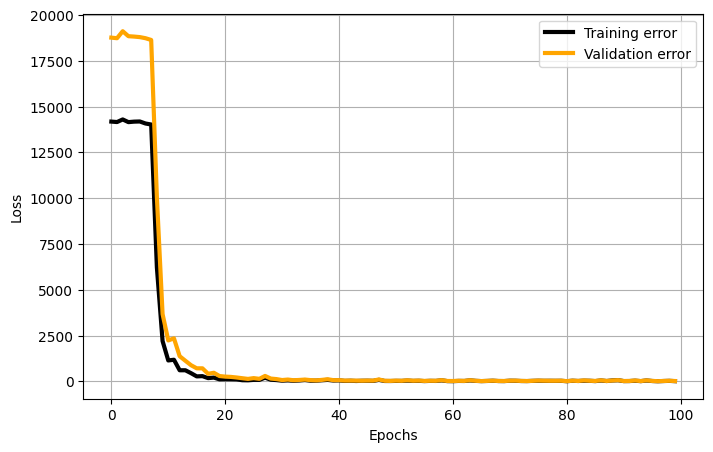

In [29]:
# TRAINING HISTORY VISUALIZATION

plt.figure(figsize = (8,5))
plt.plot(train_errors, 'k', linewidth = 3, label = 'Training error')
plt.plot(valid_errors, 'orange', linewidth = 3, label = 'Validation error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [30]:
# SHRED RECONSTRUCTION VISUALIZATION

from ipywidgets import interact, IntSlider

shred.freeze()

UVtest_proj_hat = shred(test_data_in).cpu()

Utest_proj_hat = torch.complex(UVtest_proj_hat[:, :Fourier_modes_x], UVtest_proj_hat[:, Fourier_modes_x : 2*Fourier_modes_x]).reshape(ntest, ntimes, -1)
Utest_fft_hat = torch.zeros(ntest, ntimes, nx, ny, dtype=torch.cfloat)
Utest_fft_hat[:,:,mask_x] = Utest_proj_hat
Utest_hat = torch.from_numpy(np.fft.ifft2(Utest_fft_hat).real)
Utest = Utest.reshape(ntest, ntimes, nx, ny)

Vtest_proj_hat = torch.complex(UVtest_proj_hat[:, 2*Fourier_modes_x : 2*Fourier_modes_x + Fourier_modes_y], UVtest_proj_hat[:, -Fourier_modes_y:]).reshape(ntest, ntimes, -1)
Vtest_fft_hat = torch.zeros(ntest, ntimes, nx, ny, dtype=torch.cfloat)
Vtest_fft_hat[:,:,mask_y] = Vtest_proj_hat
Vtest_hat = torch.from_numpy(np.fft.ifft2(Vtest_fft_hat).real)
Vtest = Vtest.reshape(ntest, ntimes, nx, ny)

def plot_shred_reconstruction(which_test_trajectory, which_time):

    offset = 0.1

    plt.figure(figsize = (20,5))
    plt.subplot(1, 2, 1)
    plt.contourf(x, y, vorticity(Utest[which_test_trajectory, which_time],  Vtest[which_test_trajectory, which_time]).T, cmap = 'seismic', levels = 100)
    plt.streamplot(x, y, Utest[which_test_trajectory, which_time].T, Vtest[which_test_trajectory, which_time].T, color='black', linewidth = 1, density = 1)
    plt.axis('off')
    plt.axis([0 - offset, Lx + offset, 0 - offset, Ly + offset])
    plt.title(f'Test case {which_test_trajectory} at time t = {round(t[which_time], 3)}')
    plt.grid(True)
    plt.gca().add_patch(patches.Rectangle((0, 0), Lx, Ly, linewidth = 5, edgecolor = 'black', facecolor = 'none'))
    for k in range(nsensors):
      plt.plot(sensors_coordinates[0, k], sensors_coordinates[1, k], 'o', mfc = 'magenta', mec = 'black', ms = 8, mew = 1.5)

    plt.subplot(1, 2, 2)
    plt.contourf(x, y, vorticity(Utest_hat[which_test_trajectory, which_time],  Vtest_hat[which_test_trajectory, which_time]).T, cmap = 'seismic', levels = 100)
    plt.streamplot(x, y, Utest_hat[which_test_trajectory, which_time].T, Vtest_hat[which_test_trajectory, which_time].T, color='black', linewidth = 1, density = 1)
    plt.axis('off')
    plt.axis([0 - offset, Lx + offset, 0 - offset, Ly + offset])
    plt.title(f'SHRED reconstruction at time t = {round(t[which_time], 3)}')
    plt.grid(True)
    plt.gca().add_patch(patches.Rectangle((0, 0), Lx, Ly, linewidth = 5, edgecolor = 'black', facecolor = 'none'))
    for k in range(nsensors):
      plt.plot(sensors_coordinates[0, k], sensors_coordinates[1, k], 'o', mfc = 'magenta', mec = 'black', ms = 8, mew = 1.5)

interact(plot_shred_reconstruction, which_test_trajectory = IntSlider(value = 0, min = 0, max = ntest - 1, description='Test case'), which_time = IntSlider(min = 0, max = ntimes - 1, step = 1, description='Time step'));

interactive(children=(IntSlider(value=0, description='Test case', max=9), IntSlider(value=0, description='Time…